In [150]:
# run command:$ jupyter nbconvert --to notebook --inplace --execute main.ipynb

from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np

In [137]:
# define the scaler
scaler = MinMaxScaler()

# Load MNIST dataset
mnist = fetch_openml('mnist_784')
images = mnist['data']
labels = mnist['target']

# Normalize the data
images_normalized = scaler.fit_transform(images)

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_normalized, labels, test_size=0.1)

# Print the shape of the dataset
print("(Number of images, Shape of images):", images.shape)
print("(Number of labels):", labels.shape)

(Number of images, Shape of images): (70000, 784)
(Number of labels): (70000,)


In [138]:
# Define the SVM model
svm_classifier = SVC(kernel='rbf', C=10, gamma='scale')

# train the model
svm_classifier.fit(X_train, y_train)

# Evaluate the model
accuracy = svm_classifier.score(X_test, y_test)
print("Accuracy of SVM classifier:", accuracy)


Accuracy of SVM classifier: 0.982


In [142]:
# Define the Gradient Boosting model
clf_gbt = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.05,
    max_depth=2,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    verbose=0,
)

# train the model
clf_gbt.fit(X_train, y_train)

# Evaluate the model
accuracy = clf_gbt.score(X_test, y_test)
print("Accuracy of GBT classifier:", accuracy)

Accuracy of SVM classifier: 0.982


/home/george/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/4
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.8890 - loss: 0.3552 - val_accuracy: 0.9826 - val_loss: 0.0617
Epoch 2/4
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9847 - loss: 0.0479 - val_accuracy: 0.9863 - val_loss: 0.0499
Epoch 3/4
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9898 - loss: 0.0333 - val_accuracy: 0.9886 - val_loss: 0.0413
Epoch 4/4
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.9920 - loss: 0.0255 - val_accuracy: 0.9861 - val_loss: 0.0433
Accuracy of CNN classifier: [0.04333872348070145, 0.9861428737640381]


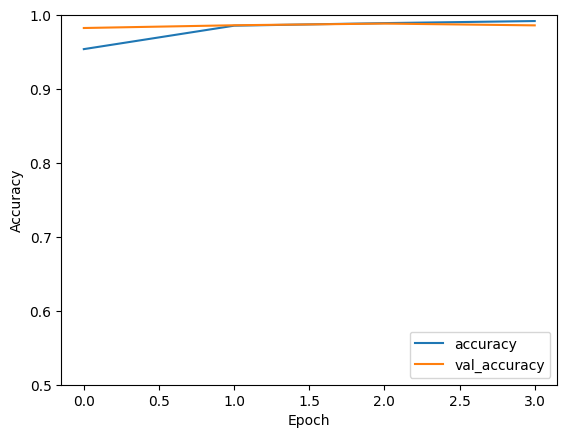

In [179]:
# Convolutional Neural Network
# Load MNIST dataset
mnist = fetch_openml('mnist_784')
images = mnist['data']
labels = mnist['target']

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_normalized, labels, test_size=0.1)

# define the Convolutional Neural Network
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# Convert labels to integer format for CNN
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Reshape data for CNN input, inputs are 28x28 gray scale
X_train_reshaped = X_train.reshape(-1, 28, 28, 1)
X_test_reshaped = X_test.reshape(-1, 28, 28, 1)

# train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train_reshaped, y_train_encoded, epochs=4, 
                    validation_data=(X_test_reshaped, y_test_encoded))

# Evaluate the model
test_acc = model.evaluate(X_test_reshaped,  y_test_encoded, verbose=0)
print("Accuracy of CNN classifier:", test_acc)

# Plot
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


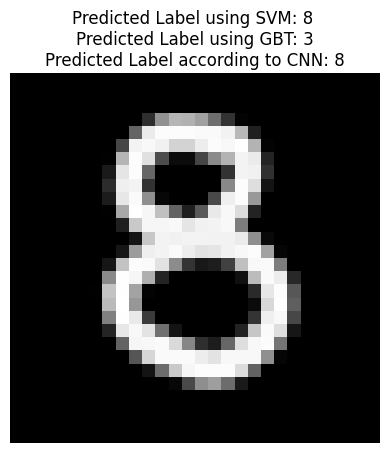

In [181]:
# convert an image I drew to test the model with

# Load the handwritten image as grayscale
image = Image.open("image.png").convert("L")

# Resize the image to 28x28 pixels
image = image.resize((28, 28))

# Invert the pixel values
image = ImageOps.invert(image)

# Convert the image to a numpy array
image_array = np.array(image)

# Flatten the image array
image_flattened = image_array.flatten()

# Scale the pixel values to the range [0, 1]
# this is equivalent to using the MinMaxScaler()
image_scaled = image_flattened / 255.0

# Predict the label using the trained models
predicted_label_svm = svm_classifier.predict([image_scaled])[0]
predicted_label_gbt = clf_gbt.predict([image_scaled])[0]

ni = image_scaled.reshape(-1, 28, 28, 1)
l = model.predict([ni])[0]
n1 = np.argmax(l)
sorted_indices = np.argsort(l)[::-1]
n2 = sorted_indices[1]

# define an image that can be shown to compare to the prediction
image_to_show = image_scaled.reshape(28, 28)

# Display the image along with the predicted labels
plt.imshow(image_to_show, cmap='gray')
plt.axis('off')
plt.title(f'Predicted Label using SVM: {predicted_label_svm} \nPredicted Label using GBT: {predicted_label_gbt}\n\
Predicted Label according to CNN: {n1}')
plt.show()
